# End-to-End Customer Segmentation Project

## Importing Libraries

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Stage 1: Data Ingestion andInitial Loading

In [6]:
# Load dataset and check missing values
try:
    df = pd.read_csv('data.csv', encoding='latin1')
    print(df.head())

    print("\nDataset info:")
    df.info()

    print("\nMissing values per column:")
    print(df.isnull().sum())
    
except FileNotFoundError:
    print("Error: 'data.csv' not found.")


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0

## Stage 2: Data Cleaning & RFM Feature Engineering

In [7]:
# Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)

df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df_cleaned = df[~df['InvoiceNo'].astype(str).str.startswith('C')].copy()
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]

print(f"Shape of dataframe after cleaning: {df_cleaned.shape}")
print(f"Remaining missing values after cleaning CustomerID NA:\n{df_cleaned.isnull().sum()}")

Shape of dataframe after cleaning: (397884, 9)
Remaining missing values after cleaning CustomerID NA:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


In [9]:
# Analysis Date one day after the latest InvoiceDate
if not df_cleaned.empty and 'InvoiceDate' in df_cleaned.columns:
    analysis_date = df_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)
else:
    
    analysis_date = dt.datetime(2011, 12, 10) 
print(f"Analysis Date: {analysis_date}")

# RFM
if not df_cleaned.empty and 'CustomerID' in df_cleaned.columns:
    rfm_df = df_cleaned.groupby('CustomerID').agg(
        Recency=('InvoiceDate', lambda x: (analysis_date - x.max()).days),
        Frequency=('InvoiceNo', 'nunique'),
        Monetary=('TotalPrice', 'sum')
    ).reset_index()
else:
    rfm_df = pd.DataFrame({
        'CustomerID': [17850, 13047, 15311],
        'Recency': [373, 30, 0],
        'Frequency': [3, 1, 1],
        'Monetary': [500.0, 100.0, 5.90]
    })

print("\nRFM DataFrame head:")
print(rfm_df.head())

Analysis Date: 2011-12-10 12:50:00

RFM DataFrame head:
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


## Stage 3: Customer Segmentation (K-Means)

In [10]:
# Feature Scaling
rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_features)
scaled_rfm_df = pd.DataFrame(scaled_features, columns=['Recency', 'Frequency', 'Monetary'])

# K-Means 
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_df['Segment'] = kmeans.fit_predict(scaled_rfm_df)

print("RFM DataFrame with Segments head:")
print(rfm_df.head())

RFM DataFrame with Segments head:
   CustomerID  Recency  Frequency  Monetary  Segment
0       12346      326          1  77183.60        3
1       12347        2          7   4310.00        0
2       12348       75          4   1797.24        0
3       12349       19          1   1757.55        0
4       12350      310          1    334.40        1


In [11]:
# Segment Profiling
segment_profile = rfm_df.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(0)

print("\nSegment Profiles (Mean RFM values):")
print(segment_profile)


Segment Profiles (Mean RFM values):
         Recency  Frequency  Monetary
Segment                              
0           44.0        4.0    1359.0
1          248.0        2.0     481.0
2            7.0       83.0  127338.0
3           16.0       22.0   12709.0


## Stage 4: Visualization 

/var/folders/75/9cdckgw11b7dp5n46n9rzphm0000gn/T/ipykernel_3617/428864110.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_profile.index, y=segment_profile[col], ax=axes[i], palette='viridis')
/var/folders/75/9cdckgw11b7dp5n46n9rzphm0000gn/T/ipykernel_3617/428864110.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_profile.index, y=segment_profile[col], ax=axes[i], palette='viridis')
/var/folders/75/9cdckgw11b7dp5n46n9rzphm0000gn/T/ipykernel_3617/428864110.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment

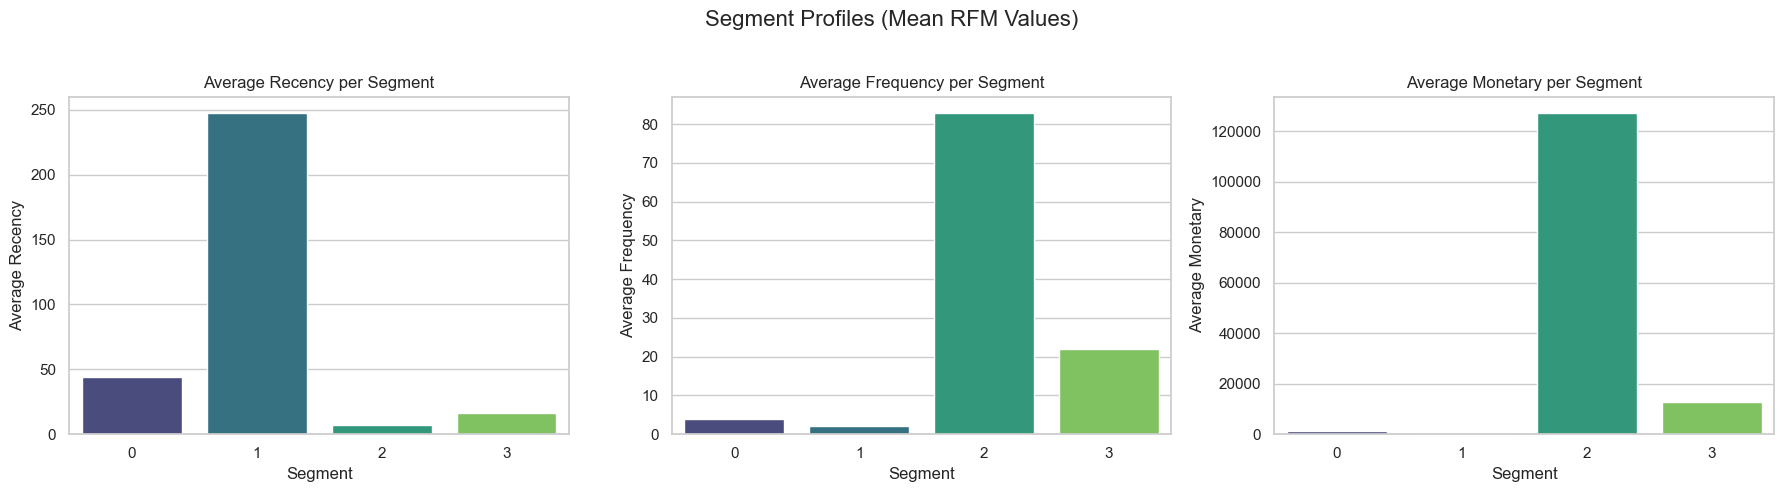

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
plt.suptitle('Segment Profiles (Mean RFM Values)', fontsize=16)

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.barplot(x=segment_profile.index, y=segment_profile[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Average {col} per Segment')
    axes[i].set_xlabel('Segment')
    axes[i].set_ylabel(f'Average {col}')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

/var/folders/75/9cdckgw11b7dp5n46n9rzphm0000gn/T/ipykernel_4426/3644897143.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='Segment', palette='viridis')


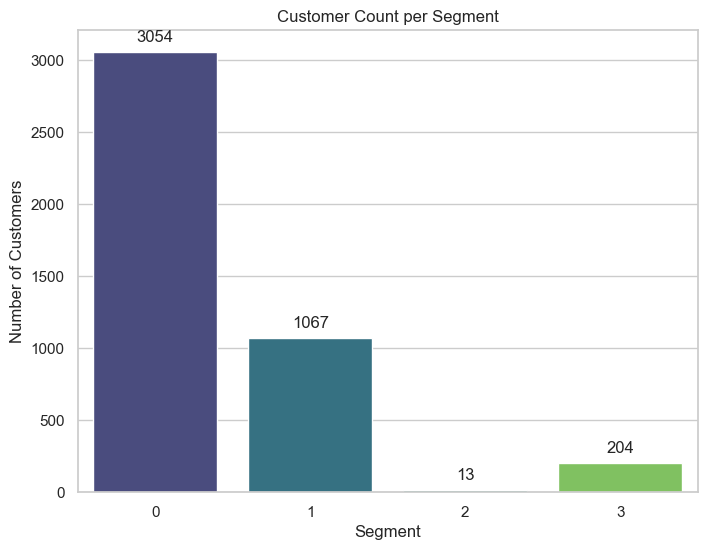

In [13]:
# Segment Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(data=rfm_df, x='Segment', palette='viridis')
plt.title('Customer Count per Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')

## Calculate segment counts for display
segment_counts = rfm_df['Segment'].value_counts().sort_index()
for i, count in enumerate(segment_counts):
    plt.text(i, count + 50, str(count), ha='center', va='bottom') 
plt.show()

In [12]:
# Calculate Estimated Revenue Percentage from High-Value Segment

high_value_segment_label = 2 

print(f"Attempting to identify High-Value Customers as those in Segment: {high_value_segment_label}")



if 'Monetary' in rfm_df.columns and 'Segment' in rfm_df.columns:
    
    high_value_customers_df = rfm_df[rfm_df['Segment'] == high_value_segment_label]

    if not high_value_customers_df.empty:
        revenue_high_value_segment = high_value_customers_df['Monetary'].sum()
        print(f"Total revenue from identified High-Value Segment ({high_value_segment_label}): ${revenue_high_value_segment:,.2f}")

        
        overall_total_revenue = rfm_df['Monetary'].sum()
        print(f"Overall Total Revenue from all segmented customers: ${overall_total_revenue:,.2f}\n")

        
        if overall_total_revenue > 0:
            percentage_revenue_from_high_value = (revenue_high_value_segment / overall_total_revenue) * 100
            print(f"The High-Value Segment ({high_value_segment_label}) drives {percentage_revenue_from_high_value:.2f}% of the total revenue.")

            
            X_revenue_percentage = percentage_revenue_from_high_value
        else:
            print("Overall total revenue is zero or less, cannot calculate percentage.")
            X_revenue_percentage = 0.0
    else:
        print(f"No customers found in the specified high-value segment ({high_value_segment_label}).")
        print("Please double-check the 'high_value_segment_label' against your 'segment_profile' output.")
        X_revenue_percentage = 0.0
        
        if 'Monetary' in rfm_df.columns:
             overall_total_revenue = rfm_df['Monetary'].sum()
             if overall_total_revenue > 0:
                print(f"Overall Total Revenue from all segmented customers (for context): ${overall_total_revenue:,.2f}")
else:
    print("Error: 'Monetary' or 'Segment' column not found in rfm_df. Ensure RFM analysis and segmentation are complete before this step.")
    X_revenue_percentage = 0.0 # Default value in case of error


Attempting to identify High-Value Customers as those in Segment: 2
Total revenue from identified High-Value Segment (2): $1,655,398.08
Overall Total Revenue from all segmented customers: $8,911,407.90

The High-Value Segment (2) drives 18.58% of the total revenue.
